<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/auflage-3/kap10/transformers-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers fine tuning on IMDB for sentiment

**for this you either need a GPU in your machine or you need to run this on Colab**

* https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
* https://huggingface.co/docs/transformers/training#train-a-tensorflow-model-with-keras
* https://huggingface.co/docs/datasets/
* https://github.com/huggingface/datasets
* https://huggingface.co/datasets/imdb

## Installation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    # https://huggingface.co/transformers/installation.html
    # https://huggingface.co/docs/datasets/installation.html
    !pip install -q transformers datasets

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [5]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [6]:
tf.random.set_seed(42)

In [7]:
!nvidia-smi

Sun Nov 12 13:45:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get and prepare data

In [8]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
example_idx = 0
raw_datasets["train"]['text'][example_idx]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [11]:
# 0: neg, 1: pos
raw_datasets["train"]['label'][example_idx]

0

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
del raw_datasets["unsupervised"]

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

In [14]:
# train_dataset = tokenized_datasets["train"]
# eval_dataset = tokenized_datasets["test"]

## Get pretrained model and fine tune

In [15]:
small_size = 1_000
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(small_size))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(small_size))

In [16]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# 1 to 3 minutes per epoch on decent GPU (e.g. V100 1min, T4 3min)
# don't train for too long, model will overfit
EPOCHS = 5
# reduce batch size when you encoder OOM error
# note, model has more than 100M parameters
# batch size 8 doable on 16GB
BATCH_SIZE = 8
# don't forget, we are fine tuning, increasing the LR might keep the model from even training
# LR = 3e-5
LR = 1e-5

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

In [19]:
%%time

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    # You don’t have to pass a loss argument to your models when you compile() them!
    # Hugging Face models automatically choose a loss that is appropriate for their task and model architecture if this argument is left blank.
    # You can always override this by specifying a loss yourself if you want to!
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=EPOCHS)

Epoch 1/5
125/125 [==============================] - 127s 531ms/step - loss: 0.5829 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.8690
Epoch 2/5
125/125 [==============================] - 57s 458ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.3273 - val_sparse_categorical_accuracy: 0.8730
Epoch 3/5
125/125 [==============================] - 57s 456ms/step - loss: 0.1107 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.4422 - val_sparse_categorical_accuracy: 0.8630
Epoch 4/5
125/125 [==============================] - 57s 459ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.4961 - val_sparse_categorical_accuracy: 0.8800
Epoch 5/5
125/125 [==============================] - 57s 457ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.5876 - val_sparse_categorical_accuracy: 0.8680
CPU times: user 3min 58s, sys: 24.2 s, total: 4min 22s
Wall time: 7min 35s


## Evaluate results

In [20]:
model.evaluate(tf_train_dataset)

125/125 [==============================] - 16s 128ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9980


[0.009805191308259964, 0.9980000257492065]

In [21]:
# training data set too small to not overfit on it
model.evaluate(tf_validation_dataset)

125/125 [==============================] - 16s 127ms/step - loss: 0.5876 - sparse_categorical_accuracy: 0.8680


[0.5875745415687561, 0.8679999709129333]

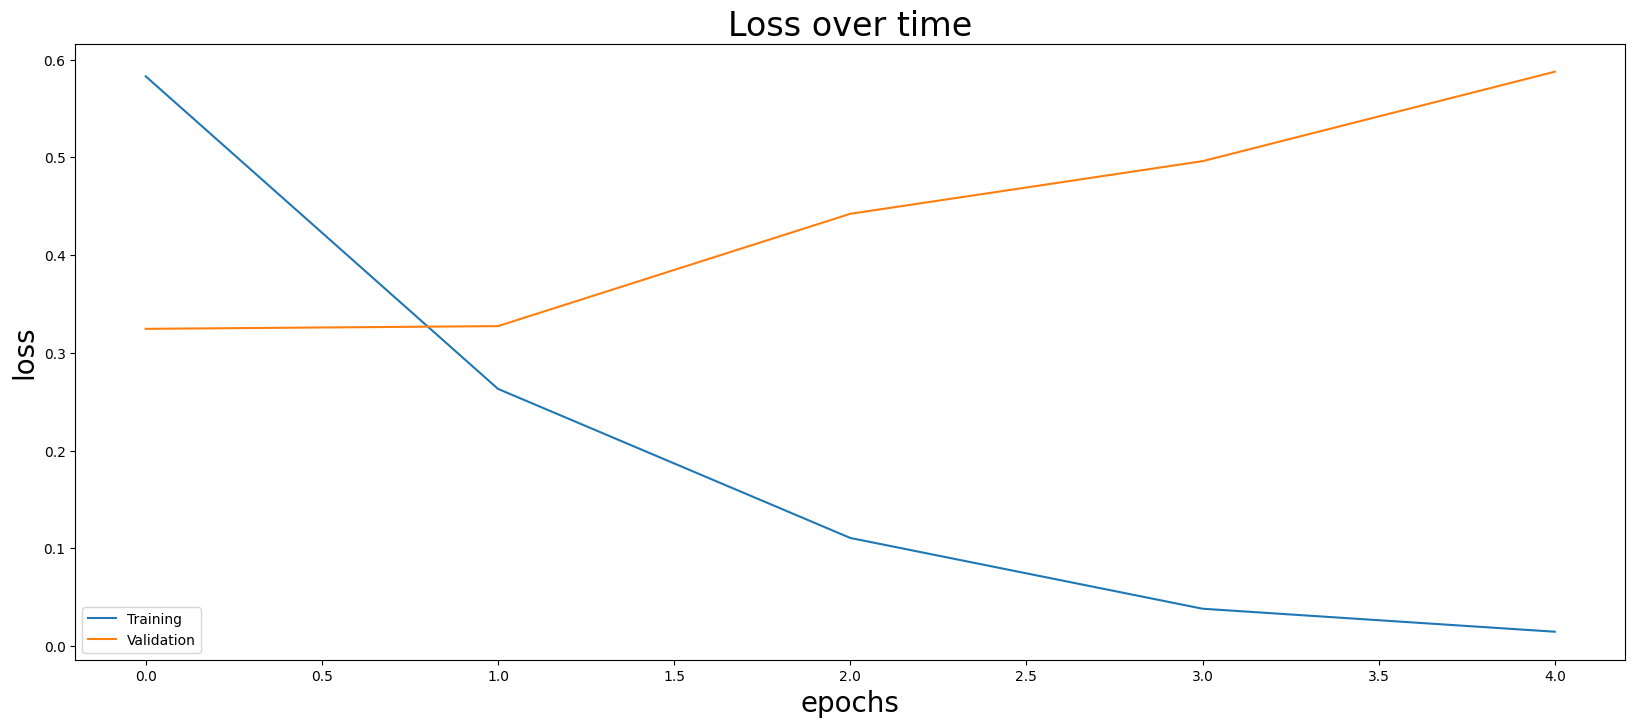

In [22]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

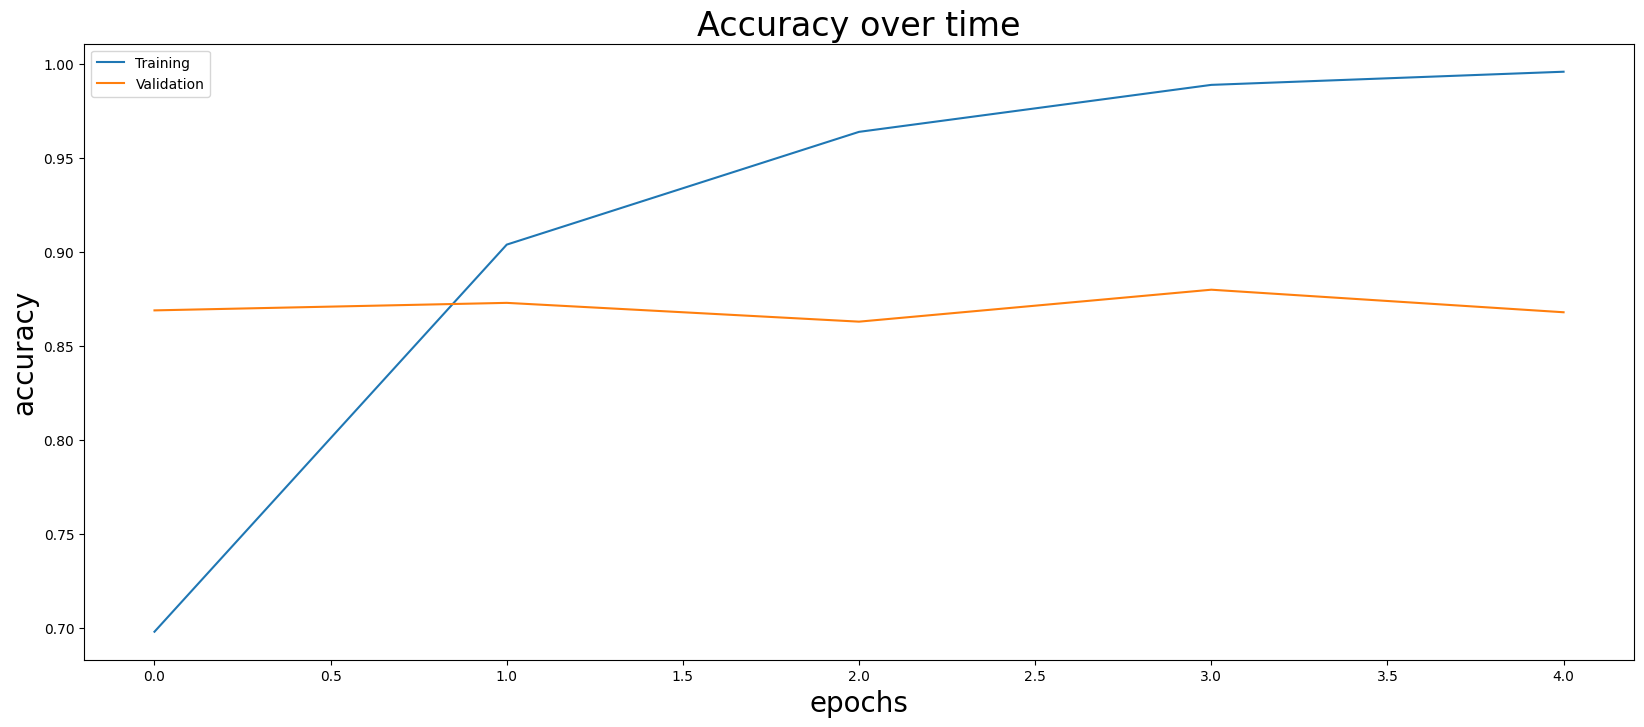

In [23]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Try out our fine tuned model

Quoting from https://huggingface.co/datasets/imdb
* neg: 0
* pos: 1

https://huggingface.co/transformers/task_summary.html#sequence-classification

In [24]:
movie1 = 'Two small cats seek and find adventures. Nice if you like cute movies.'

In [25]:
movie2 = 'Zombies attack a kindergarden. Splatter!'

In [26]:
movies = [movie1, movie2]

In [27]:
inputs = tokenizer(movies, padding="max_length", truncation=True, return_tensors="tf")

In [28]:
# this seems to be a good movie
tf.nn.softmax(model(inputs)[0])[0].numpy()

array([0.01681681, 0.98318315], dtype=float32)

In [29]:
# this one not so much
tf.nn.softmax(model(inputs)[0])[1].numpy()

array([0.6547532 , 0.34524673], dtype=float32)